# Import MNIST

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,Y=mnist['data'],mnist['target']
X=X.values #convert into array
Y=Y.astype('uint8')

plot

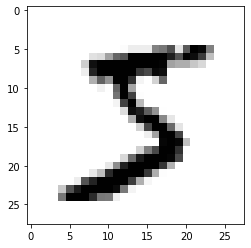

In [29]:
plt.imshow(np.reshape(X[0],(28,28)), cmap='binary')

convert Y into int

Split train and test:

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [31]:
X.shape

(70000, 784)

In [32]:
X_train, X_test, Y_train, Y_test= X[:60000,:], X[60000:, :], Y[:60000], Y[60000:]

The training data is already shuffled. In some cases where classification is associated with time series data, shuffling is not a good idea

## Toy example a '5' detector

both are binary vectors that either say yes for 5 or no otherwise

In [33]:
y_train_5=(Y_train==5)

In [34]:
y_test_5=(Y_test==5)

### sgd classifier

In [14]:
from sklearn.linear_model import SGDClassifier


In [15]:
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [35]:
#feed it a 5
sgd_clf.predict([X[0]])

array([ True])

### cross-validation score custom function

In [36]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)#stratified sampling

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    #spits out train and test indices for each split
    clone_clf = clone(sgd_clf) #at each instance, create a colone of the classifier that only sees that fold
    X_train_folds = X_train[train_index] 
    y_train_folds = y_train_5[train_index] 
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.95035
0.96035
0.9604


In [37]:
from sklearn.model_selection import cross_val_score

now using built in function

In [38]:
cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring='accuracy')b


array([0.95035, 0.96035, 0.9604 ])

since only looking at 5, the chances of high accuracy are very likely

In [40]:
np.sum(y_train_5)/len(y_train_5) 
#about 10% of the indices are 5's, so the likelyhood of guessing correctly on them is increased

0.09035

a dumb NO 5 classifier

In [45]:
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None): 
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)#return 0 for all

In [46]:
never5=Never5Classifier()
cross_val_score(never5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- If we change predictor to always predict 5, the accuracy is inverse, around 10%. This is because most of the data is NOT 5
- Accuracy is not the best metric, espeically when looking at **skewed** datasets

## Confusion Matrix

- a confusion matrix gives a deeper idea than pure accuracy, it gives *ratios* of **predicted** classes. It normally looks something like:

NEG |POS |
-----|-----|
True Negative|False Positive|
False Negative|True Positive|

- where the true class is the rows and predicted classes are the columns. 
- Therefore, the positive diagonal is the true measures, whereas the negative diagonal gives error

### cross vall PREDICT

In [48]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Precision and Recall

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

Precision:

- What proportion of all positive identifications was actually correct?

$\large Precision = \frac{TP}{TP+FP}$


Specificity is the accuracy of the *positive* predictions only

- what percentage of the actual negatives were correctly identified

$\large Specificity = \frac{TN}{TN+FP}$

Recall or Sensitivity or True Positive rate:

what percentage of the ACTUAL positives were truly identified
    
$\large Recall = \frac{TP}{TP+FN}$

In [51]:
from sklearn.metrics import precision_score, recall_score

In [54]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [55]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**F1** score combines both measures thorugh a harmonic mean

- a harmonic mean is the reciprocal of the arithmetic mean of the reciprocals

eg. 1,4,4

$(\frac{1^{-1}+4^{-1}+4^{-1}}{3})^{-1}$


$\large F1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$

$\large = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [56]:
from sklearn.metrics import f1_score

In [57]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

This score prioritizes an *even* relationship between precision and recall, which may not always be ideal. For example, if the classification is videos with nudity, then you care about low false postivies (0=unsafe, 1=safe), a FP would say a video is safe when its not. Therefore, care about high precision. It's okay to reject some good videos and have a high # of FN (low recall).

In the other case, if a shopliftic classifier (0=suspect 1=innocent), then it's better to overestimate the suspects, that is have a high # of FP is ok. The real problem is FN, which means letting theives get through. In this case, we care more about having a high recall

**Precision and Recall Trade-Off**

- Everything past the threshold is considered a positive classification
- The classification threshold dictates this trade-off. If we increase the threshold, we get a lot more precision because the false positives go down, however, now there are a lot more false negatives, thus lower recall. 

While we can't adjust the threshold in sklearn directly, we can get an idea of it through decision 'scores' 

In [60]:
y_scores=sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

- we can set our own thresholds based on these scores to return true or false
- alternatively, plotting the curves allows us to pick a range systematically

In [63]:
#1. get decision scores through cross validation

y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [64]:
#2. now use precision recall curve to plot 

from sklearn.metrics import precision_recall_curve

In [67]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [73]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.xlim([-40000, 40000])
    plt.xlabel('Threshold')

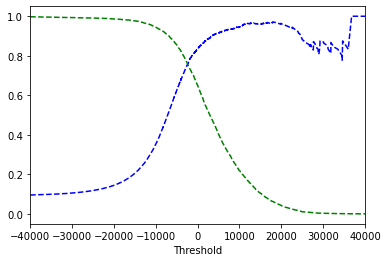

In [74]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0, 0.5, 'precision')

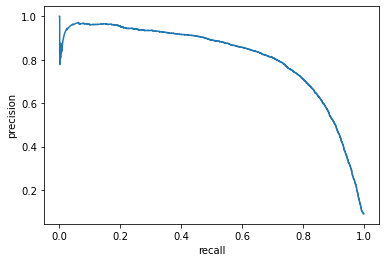

In [76]:
#another option is to plot the recall vs the precision directly

plt.plot(recalls, precisions)
plt.xlabel('recall')
plt.ylabel('precision')

There is a sharp drop-off at 0.8 recall, so want to be before that

In [77]:
#to get the score at a particular decision level

threshold_90_precision= thresholds[np.argmax(precisions>=0.9)]#gives the index of the first to beat 0.9

In [78]:
threshold_90_precision

3370.0194991439557

In [79]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [80]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293